## Importing Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

## Importing Dataset

In [4]:
train='/content/drive/My Drive/duck_chicken_data/train'

In [5]:
val='/content/drive/My Drive/duck_chicken_data/val'

In [32]:
test='/content/drive/My Drive/duck_chicken_data/test/'

## Preparing Dataset

In [7]:
# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)


# Creating generator object of training images
train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 246 images belonging to 2 classes.


In [8]:
val_datagen=ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

val_generator = train_datagen.flow_from_directory(val,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 24 images belonging to 2 classes.


In [9]:
labels=['chicken','duck']

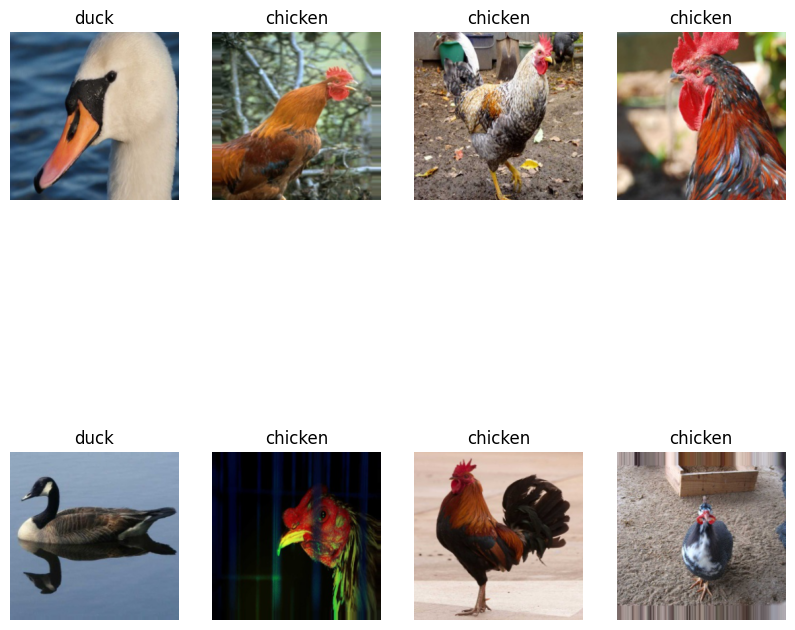

In [10]:
plt.figure(figsize=(10,10))
batch,p = train_generator.next()
for i in range(1,9):
   plt.subplot(2,4, i)
   
   image = batch[i]
   plt.imshow(image)

   #The labels are one-hot encoded, so need to find position with value 1
   plt.title(labels[np.argmax(p[i])])
   plt.axis('off')
plt.show()

## Model

In [11]:
# We are using a VGG-16 model with "imagenet" weights
model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(256,256,3))

58889256/58889256 [==============================] - 4s 0us/step


In [12]:
#These layers will not be trained
for layers in model.layers:
  layers.trainable=False


#Taking the last layer of the VGG-16 layer
last_output = model.output


#Adding a Flatten layer
vgg_x = Flatten()(last_output)


#Adding a Dense layer for linear output
vgg_x = Dense(128, activation = 'relu')(vgg_x)


#The output layer will give 6 values, a probability distribution for each label
vgg_x = Dense(2, activation = 'softmax')(vgg_x)


#Connecting the linear layers to the VGG-16 model
vgg16_final_model = Model(model.input, vgg_x)

#Compiling the model
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [13]:
vgg16_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
vgg16_final_model.fit(train_generator,steps_per_epoch=len(train_generator),epochs=5,validation_data=val_generator,validation_steps=len(val_generator))

Epoch 1/5
8/8 [==============================] - 90s 10s/step - loss: 0.7309 - accuracy: 0.5041 - val_loss: 0.6530 - val_accuracy: 0.7083
Epoch 2/5
8/8 [==============================] - 6s 749ms/step - loss: 0.6386 - accuracy: 0.6138 - val_loss: 0.5762 - val_accuracy: 0.6667
Epoch 3/5
8/8 [==============================] - 5s 567ms/step - loss: 0.5714 - accuracy: 0.7114 - val_loss: 0.5329 - val_accuracy: 0.9167
Epoch 4/5
8/8 [==============================] - 5s 649ms/step - loss: 0.5279 - accuracy: 0.7561 - val_loss: 0.4787 - val_accuracy: 0.8750
Epoch 5/5
8/8 [==============================] - 5s 552ms/step - loss: 0.4931 - accuracy: 0.8008 - val_loss: 0.4535 - val_accuracy: 0.8333


In [15]:
#Saving the model
vgg16_final_model.save('vgg_multi_classifier.h5')

In [16]:
#Loading the model
vgg_m=load_model('vgg_multi_classifier.h5')

In [21]:
tst=dict()
tst["image"]=[]
tst["label"]=[]
for l in ["chicken","duck"]:
  for name in os.listdir(os.path.join(test,l)):
    tst["image"].append(name)
    tst["label"].append(l)

In [22]:
test_data=pd.DataFrame(tst)
test_data.head()

,image,label
0,3PAKQG6U95KF.jpg,chicken
1,3LMOHKHBDS3X.jpg,chicken
2,2GGVG9VUE5VP.jpg,chicken
3,BI4ECAWKXT6F.jpg,chicken
4,CAI6198JI3O3.jpg,chicken


In [23]:
for i in range(len(test_data)): 
  image=os.path.join(test,test_data.loc[i,"label"],test_data.loc[i,"image"])
  img_pred_1=tf.keras.utils.load_img(image,target_size=(256,256))
  img_pred_1=tf.keras.utils.img_to_array(img_pred_1)
  img_pred_1=np.expand_dims(img_pred_1, axis=0)
  rslt= vgg16_final_model.predict(img_pred_1)
  test_data.loc[i,"pred"]=np.argmax(rslt)

1/1 [==============================] - 0s 84ms/step


In [24]:
for i in range(len(test_data)):
  if test_data.loc[i,"label"]=="chicken":
    test_data.loc[i,"true"]=0
  else:
    test_data.loc[i,"true"]=1

In [25]:
print(classification_report(test_data["true"], test_data["pred"], target_names=["chicken","duck"]))

              precision    recall  f1-score   support

     chicken       0.52      1.00      0.69        12
        duck       1.00      0.08      0.15        12

    accuracy                           0.54        24
   macro avg       0.76      0.54      0.42        24
weighted avg       0.76      0.54      0.42        24



In [31]:
print(tst)

{'image': ['3PAKQG6U95KF.jpg', '3LMOHKHBDS3X.jpg', '2GGVG9VUE5VP.jpg', 'BI4ECAWKXT6F.jpg', 'CAI6198JI3O3.jpg', 'FNIDE6R4NAJL.jpg', 'FSBW9G375NPR.jpg', 'OXZZ7KMKO69Z.jpg', 'PD9CHRW0GT3Z.jpg', 'OHIFDA3EP9JI.jpg', 'PPS83G2DYRE0.jpg', 'Q183ZB9C0N1V.jpg', '60IZ50I5MBH4.jpg', '89ON58M4S8ET.jpg', '68SQUOUZ6P65.jpg', 'C11MD7YKYO14.jpg', 'CYG0RR12U9QK.jpg', 'CWHPBWCX1MU7.jpg', 'CQH6AW58PZFF.jpg', 'CCMO8KDST33C.jpg', 'CB3ZPH5MSUW9.jpg', 'C62STRYJP88G.jpg', 'D3BG48CHKUVV.jpg', 'DRFKXHCX2TZ6.jpg'], 'label': ['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck', 'duck']}


1/1 [==============================] - 0s 20ms/step


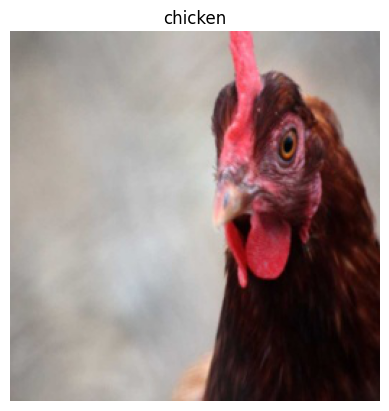

In [37]:
#Loading the image and converting to 256*256 size 
img_pred_1=tf.keras.utils.load_img(os.path.join(test,'chicken/2GGVG9VUE5VP.jpg'),target_size=(256,256))
img_pred_1=tf.keras.utils.img_to_array(img_pred_1)
img_pred_1=np.expand_dims(img_pred_1, axis=0)


# Predicting the label
rslt= vgg16_final_model.predict(img_pred_1)


# Showing the label
l1=labels[np.argmax(rslt)]

plt.imshow(img_pred_1[0]/255.0)
plt.title(l1)
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 28ms/step


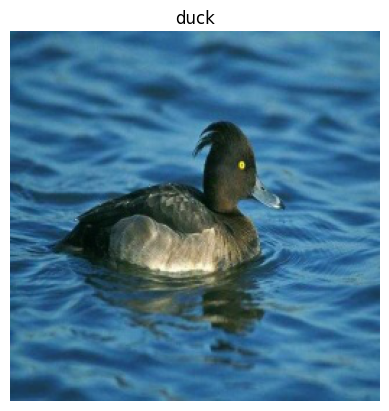

In [45]:
#Loading the image and converting to 256*256 size 
img_pred_2=tf.keras.utils.load_img(os.path.join(test,'duck/00AONW8ADLQD.jpg'),target_size=(256,256))
img_pred_2=tf.keras.utils.img_to_array(img_pred_2)
img_pred_2=np.expand_dims(img_pred_2, axis=0)


# Predicting the label
rsl= vgg16_final_model.predict(img_pred_2)


# Showing the label
l2=labels[np.argmax(rsl)]

plt.imshow(img_pred_2[0]/255.0)
plt.title(l2)
plt.axis("off")
plt.show()